<a href="https://colab.research.google.com/github/sl202194dsdj/supply_chain_analytics/blob/master/run_cnn_rv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
#Install deep learning libs
!pip install tensorflow-gpu

     |████████████████████████████████| 516.2MB 27kB/s 


In [4]:
!pip install mlxtend==0.17.0

     |████████████████████████████████| 1.3MB 12.9MB/s 
  Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0


In [5]:
#Install ABOD
!pip install pyod

     |████████████████████████████████| 102kB 7.6MB/s 
     |████████████████████████████████| 2.1MB 13.0MB/s 
  Created wheel for pyod: filename=pyod-0.8.0-cp36-none-any.whl size=105563 sha256=65e4657ea41345d70aecafc4b9e7cb63e396222c6cbafe66bebf2e1b050317a2
  Stored in directory: /root/.cache/pip/wheels/ba/a6/81/2dd042e240090f3603a686b897d03402219a86e3f61bc71184
  Created wheel for combo: filename=combo-0.1.0-cp36-none-any.whl size=42043 sha256=1de0ddde6a3d41a62269cefecf25c1256706157cd411c078a92b28edd1de63f0
  Stored in directory: /root/.cache/pip/wheels/00/fd/6c/8da495ef08ce61844a646df2423c2b8ecda377a89c90ecd88e
  Created wheel for suod: filename=suod-0.0.4-cp36-none-any.whl size=2167157 sha256=1db2649a24963dc03f049d4d923898f9e579e6c4c030e38f2ec539f419b70c6d
  Stored in directory: /root/.cache/pip/wheels/57/55/e5/a4fca65bba231f6d0115059b589148774b41faea25b3f2aa27
Successfully built pyod combo suod


In [6]:
!pip install imbalanced-learn

In [7]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import  Flatten, Dense, Conv1D, MaxPool1D, Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
print(tf.__version__)

2.2.0


In [0]:
#Import helpers
!cp "/content/drive/My Drive/back_order_predictor_v2/helpers/helpers.py" .
!cp "/content/drive/My Drive/back_order_predictor_v2/helpers/make_confusion_matrix.py" .

In [0]:
import sys

In [0]:
sys.path.append("/content/drive/My Drive/back_order_predictor_v2/helpers")

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import make_confusion_matrix
import helpers
import math

In [0]:
import numpy as np 
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.pipeline import make_pipeline
import sklearn.preprocessing
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
#from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
#from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.linear_model import LogisticRegression
#from sklearn import svm
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#from catboost import CatBoostClassifier
from sklearn.preprocessing import PowerTransformer


#from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import pickle
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

#to adjust figsize of plots
plt.rcParams['figure.figsize'] = (20,6)
pd.set_option('display.max_columns', None)

In [0]:
#Define data file path and target variable
#file = 'derived_data/validate_data.csv'
file = "/content/drive/My Drive/back_order_predictor_v2/derived_data/train_data.csv"
target = 'went_on_backorder_Yes'
#test_features = pd.read_csv('derived_data/test_data.csv')

In [0]:
class Data():
    '''Loads data, samples training data if specified, assigns features_df and target_df
    '''
    def __init__(self, file, target, sample=False, n_samples=None):
        self.file = file
        self. sample = sample
        self.n_sample = n_sample
        self.target = target
    
    def get_data(file, sample=False, n_samples=None):
        '''Loads train data with option to sample'''
        data = pd.read_csv(file)
        if sample:
            '''Sample train data due to resource limitation'''
            data = data.sample(n_samples, random_state=123)
        else:
            data = data
        print(data.shape, 'data loaded')
        return data
         
    def get_features():
        '''Assigns features dataframe'''
        features_df = data.drop(target, axis = 1)
        print(features_df.shape, 'features assigned')
        return features_df
        
    def get_target():
        '''Assigns target'''
        target_df = data[target].values
        print(target_df.shape, '...target rows loaded')
        return target_df
    

class FeatureSelector(BaseEstimator, TransformerMixin):
    '''Custom transformer to extract columns passed as arguments'''
    
    def __init__(self, feature_names):
        '''Class constructor'''
        self._feature_names = feature_names
        
    def fit(self, features_df, target = None):
        '''Returns self and nothing else'''
        return self
    
    def transform( self, features_df, target = None):
        '''This method returns selected features'''
        return features_df[ self._feature_names] 
    

class FeatureSelector(BaseEstimator, TransformerMixin):
    '''Custom transformer to extract columns passed as arguments'''
    
    def __init__(self, feature_names):
        '''Class constructor'''
        self._feature_names = feature_names
        
    def fit(self, features_df, target = None):
        '''Returns self and nothing else'''
        return self
    
    def transform( self, features_df, target = None):
        '''This method returns selected features'''
        return features_df[ self._feature_names] 
    

class DropMissing(BaseEstimator, TransformerMixin, object):
    '''Takes df, drops all observaions with missing values
    '''
    features_df_test = pd.DataFrame()
    def __init__(self, features_df):
        self.features_df = features_df

    def fit(self, features_df, target=None):
        return self
    
    def transform(self, features_df, target=None):
        features_df_test = features_df.dropna(axis = 0, how = 'any', inplace = False)
        return features_df_test
    

class BinNumeric(BaseEstimator, TransformerMixin):
    '''Takes numeric column, returns binned column
     Args:
         bins: list of class bins
         col: Numerical column to bin
    '''
    #col=None
    bins=[0,6,11,35]
    def __init__(self, features_df):
        self.features_df = features_df
        #self.bins = bins
        #self.col = col
        
        
    def fit(self, features_df, target=None):
        return self
    
    def transform(self, features_df, target=None):
        #BinNumeric.col = col
        #features_df['binned'] = np.searchsorted(bins, features_df[BinNumeric.col].values)
        #features_df.drop
        #bins=[0,6,11,35]
        features_df['binned'] = np.searchsorted(BinNumeric.bins, features_df.iloc[:,0].values)
        return features_df

#bins = [0,6,11,35]
#data['leadtime_binned'] = np.searchsorted(bins,data['lead_time'].values)    

class PowerTransform(BaseEstimator, TransformerMixin):
    '''Takes df, applies power transformation
    '''
    def __init__(self, features_df, target=None):
        self.features_df = features_df
    
    def fit(self, features_df, target=None):
        return self

    def transform(self, features_df, target=None):
        power = PowerTransformer(method= 'yeo-johnson', standardize=True)
        
        #Apply power transformation to features df
        features_df = power.fit_transform(features_df)

        return features_df
    
    
class DelUnusedCols(BaseEstimator, TransformerMixin):
    '''This transformer deletes unused columns from a data pipeline
       Column 14,15, and 16 holds original columns that were transformed through one-hot encoding.
       These columns are no longer needed
    '''    
    def __init__(self, features_df, target=None):
        self.features_df = features_df
        
    def fit(self, features_df, target=None):
        return self
    
    def transform(self, features_df, target=None):
        a = features_df.values
        #Delete work, family, and state features
        #a = np.delete(a,[7,8,9],1)
        a = np.delete(a,[0],1)
        features_df = a
        return features_df

In [48]:
if __name__ == '__main__':
    
    #Load data
    data = Data.get_data(file, sample=True, n_samples = 10000)
    features_df = Data.get_features()
    target_df = Data.get_target()
    
    '''Data transformation pipelines'''
    #Categrical features to pass down categorical pipeline 
    categorical_features = ['lead_time','oe_constraint_Yes', 'potential_issue_Yes',
                       'ppap_risk_Yes','stop_auto_buy_Yes']

    #Numerical features to pass down numerical pipeline 
    numerical_features = ['lead_time','national_inv','in_transit_qty', 'sales_1_month',
                     'pieces_past_due']
    
    #Defining steps in the categorical pipeline 
    categorical_pipeline = Pipeline( steps = [('cat_selector', FeatureSelector(categorical_features)),
                                                                                                                              
                                              #('drop_missing', DropMissing(features_df)),
                                              
                                              ('bin_numeric', BinNumeric(features_df)),
                                          
                                              ('delete_unused', DelUnusedCols(features_df))
                                         
                                         ])
    
    #Defining the steps in the numerical pipeline 
    numerical_pipeline = Pipeline( steps = [('num_selector', FeatureSelector(numerical_features)),
                                        
                                            #('drop_missing', DropMissing(features_df)),
                                            
                                            ('delete_unused', DelUnusedCols(features_df)),
                                        
                                            ('power_transform', PowerTransform(features_df))
                                   
                                       ] )
    
    #Combine numerical and categorical pieplines horizontally using FeatureUnion
    full_pipeline = FeatureUnion( transformer_list = [('categorical_pipeline', categorical_pipeline), 
                                                  
                                                      ('numerical_pipeline', numerical_pipeline )])
    #Disabling pandas chained_assignment warning
    pd.options.mode.chained_assignment = None
    
    #Fitting data to data transformation pipeline
    prepared_features_df = full_pipeline.fit_transform(features_df, target_df)

(10000, 23) data loaded
(10000, 22) features assigned
(10000,) ...target rows loaded


In [49]:
prepared_features_df

array([[ 0.        ,  0.        ,  0.        , ..., -0.50480336,
        -0.79919206, -0.11431791],
       [ 0.        ,  0.        ,  1.        , ..., -0.50480336,
        -0.79919206, -0.11431791],
       [ 0.        ,  0.        ,  1.        , ..., -0.50480336,
        -0.79919206, -0.11431791],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  1.77571404,
         1.45214542, -0.11431791],
       [ 0.        ,  0.        ,  0.        , ..., -0.50480336,
        -0.79919206, -0.11431791],
       [ 0.        ,  0.        ,  0.        , ..., -0.50480336,
         0.19155881, -0.11431791]])

In [50]:
# Split the columns of data into input and output variables.
# split into input (X) and output (y) variables
X = prepared_features_df
y = target_df
print(X.shape, y.shape)

(10000, 9) (10000,)


In [52]:
test_df = pd.read_csv("/content/drive/My Drive/back_order_predictor_v2/derived_data/train_data.csv")
print(test_df.shape)

(1350288, 23)


In [44]:
test_df.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,min_bank,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,potential_issue_Yes,deck_risk_Yes,oe_constraint_Yes,ppap_risk_Yes,stop_auto_buy_Yes,rev_stop_Yes,went_on_backorder_Yes
0,1486266,139.0,8.0,6.0,0.0,350.0,350.0,18.0,52.0,115.0,185.0,24.0,0.0,0.98,0.99,0.0,0,0,0,0,1,0,0
1,1468661,-2.0,14.0,0.0,3.0,24.0,32.0,10.0,31.0,33.0,33.0,18.0,0.0,0.91,0.88,2.0,0,0,0,0,1,0,0
2,2140959,7529.0,8.0,8.0,2500.0,2500.0,2500.0,71.0,114.0,1563.0,2419.0,117.0,0.0,1.00,1.00,0.0,0,0,0,0,1,0,0
3,2197644,792.0,8.0,6.0,0.0,0.0,0.0,7.0,41.0,99.0,192.0,24.0,0.0,0.83,0.91,0.0,0,0,0,0,1,0,0
4,1943809,3.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,6.0,6.0,0.0,0.0,0.38,0.40,0.0,0,0,0,0,1,0,1


In [0]:
del test_df

# Load Data
Note that to constract an ANN we need to have data as an array

In [0]:
url = "/content/drive/My Drive/back_order_predictor_v2/derived_data/train_data_abt.csv"
dataset = pd.read_csv(url, header=0)
print(dataset.shape)

(2521286, 9)


In [0]:
dataset.head()

,national_inv,in_transit_qty,sales_1_month,pieces_past_due,potential_issue_Yes,oe_constraint_Yes,ppap_risk_Yes,stop_auto_buy_Yes,backorder
0,-0.005243,1.938134,1.458893,-0.127225,-0.023405,-0.012521,-0.367299,0.159142,0
1,-0.066974,-0.512815,1.286355,-0.127225,-0.023405,-0.012521,-0.367299,0.159142,0
2,1.043200,1.992982,1.696634,-0.127225,-0.023405,-0.012521,-0.367299,0.159142,0
3,0.148776,1.938134,1.154579,-0.127225,-0.023405,-0.012521,-0.367299,0.159142,0
4,-0.061233,-0.512815,-0.816526,-0.127225,-0.023405,-0.012521,-0.367299,0.159142,1


In [0]:
#Sample data to manage training time
#Sample data to manage training time
data = dataset.sample(frac=0.01, random_state=7)
print(data.shape)

(25213, 9)


In [0]:
#Convert to numy array
data = data.to_numpy()

In [0]:
data

array([[-0.03515459, -0.51281501, -0.81652628, ..., -0.36729874,
         0.15914236,  0.        ],
       [-0.0606592 , -0.51281501,  1.41092772, ...,  2.72257942,
         0.15914236,  1.        ],
       [-0.00492803, -0.51281501,  1.59774747, ..., -0.36729874,
         0.15914236,  0.        ],
       ...,
       [-0.06302699, -0.51281501, -0.81652628, ..., -0.36729874,
         0.15914236,  1.        ],
       [-0.06302699, -0.51281501,  0.75694978, ..., -0.36729874,
         0.15914236,  1.        ],
       [ 0.0214535 ,  2.0366684 ,  1.5927375 , ..., -0.36729874,
         0.15914236,  0.        ]])

In [0]:
# Split the columns of data into input and output variables.
# split into input (X) and output (y) variables
X = data[:,0:8]
y = data[:,8]
print(X.shape, y.shape)

(25213, 8) (25213,)


In [0]:
#Split data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, 
                                                    random_state=7, stratify=y)

In [26]:
print(X_train.shape, X_test.shape)

(8000, 9) (2000, 9)


# Define Model

In [0]:
# define the keras model
model = Sequential()
model.add(Dense(12, input_dim=9, activation='relu'))
model.add(Dense(9, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Define Custom Metric

In [0]:
#Trying to use a custom metric for recall
#See https://stackoverflow.com/questions/43345909/when-using-mectrics-in-model-compile-in-keras-report-valueerror-unknown-metr/43354147#43354147

import keras.backend as K

def f1_score(y_true, y_pred):

    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # If there are no true samples, fix the F1 score at 0.
    if c3 == 0:
        return 0

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score


In [0]:
# compile the keras model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [0]:
# fit the keras model on the dataset
history = model.fit(X_train, y_train, epochs=150, batch_size=10, validation_split=0.2, verbose=0)

In [0]:
# evaluate the keras model
_, accuracy = model.evaluate(X_train, y_train)
print('Accuracy: %.2f' % (accuracy*100))

631/631 [==============================] - 1s 2ms/step - loss: 0.3646 - accuracy: 0.8395
Accuracy: 83.95


In [0]:
# make probability predictions with the model
predictions = model.predict(X_test)
# round predictions 
rounded = [round(x[0]) for x in predictions]

In [38]:
#Sanity check first five predictions
rounded[:5]

[0.0, 0.0, 0.0, 0.0, 0.0]

# Get Confusion Matrix

In [39]:
#Get the confusion matrix
cf_matrix = confusion_matrix(rounded, y_test)
print(cf_matrix)

[[1985   11]
 [   4    0]]


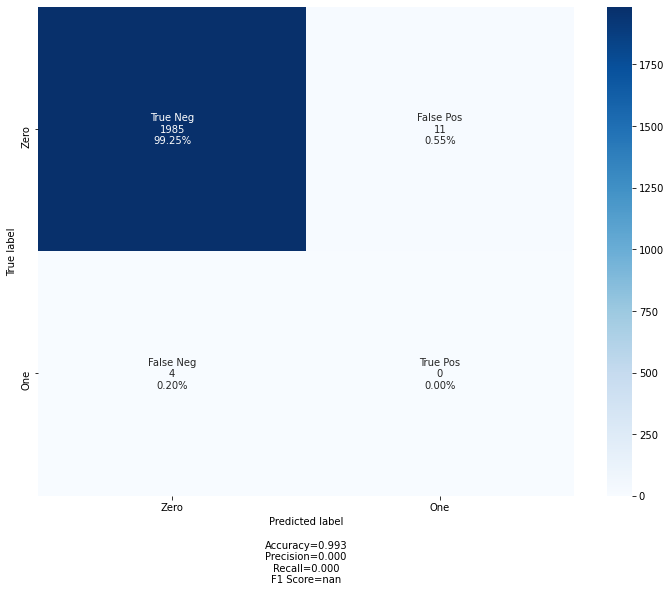

In [40]:
#Pretty confusion_matrix
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix.make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories,
                      figsize=(12, 9)
                     )

# Save Model

In [0]:
model

In [0]:
# save model and architecture to single file
model.save("drive/My Drive/back_order_predictor_v2/cnn_model.h5")
print("Saved model to disk")

Saved model to disk


# Load Model

In [0]:
pwd

'/content'

In [0]:
!ls

drive  helpers.py  make_confusion_matrix.py  __pycache__  sample_data


In [0]:
# load and evaluate a saved model
from numpy import loadtxt
from keras.models import load_model
 
# load model
#model = load_model('cnn_model.h5')
model = tf.keras.models.load_model("drive/My Drive/back_order_predictor_v2/cnn_model.h5")

# summarize model.
model.summary()

# load dataset
#Note 'url' is defined earlier
dataset = pd.read_csv(url, header=0)
data = dataset.to_numpy()

# split into input (X) and output (y) variables
X = data[:,0:8]
y = data[:,8]

# evaluate the model
score = model.evaluate(X, y, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 12)                108       
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 104       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 221
Trainable params: 221
Non-trainable params: 0
_________________________________________________________________
accuracy: 84.84%


# Estimating a Stochastic Model's Skill

Here we'll rerun our model multiple (k) times to estimate the skill of our model

In [0]:
#Selecting k
k = range(1,10)

In [0]:
scores = list()
for i in k:
    #train, test = split_old(data, i)
    X_train,X_test, y_train, y_test = train_test_split(X,y, test_size = i/10,
                                  random_state=7, stratify=y)
    
    # define the keras model
    model = Sequential()
    model.add(Dense(12, input_dim=8, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    # compile the keras model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
         
    #fit
    model.fit(X_train, y_train, epochs=150, batch_size=10, verbose=0)
    
    # evaluate the keras model
    _, accuracy = model.evaluate(X_test, y_test)
    
    #Get scores
    scores.append(accuracy*100)
    print('Fold ', i,' fitted\n')
    #print("%s: %.2f%%" % (model.metrics_names[1], accuracy[1]*100))

79/79 [==============================] - 0s 2ms/step - loss: 0.3614 - accuracy: 0.8469
Fold  1  fitted

158/158 [==============================] - 0s 2ms/step - loss: 0.3636 - accuracy: 0.8511
Fold  2  fitted

237/237 [==============================] - 1s 2ms/step - loss: 0.5527 - accuracy: 0.8451
Fold  3  fitted

316/316 [==============================] - 1s 2ms/step - loss: 0.3632 - accuracy: 0.8529
Fold  4  fitted

394/394 [==============================] - 1s 2ms/step - loss: 0.3972 - accuracy: 0.8194
Fold  5  fitted

473/473 [==============================] - 1s 2ms/step - loss: 0.3789 - accuracy: 0.8509
Fold  6  fitted

552/552 [==============================] - 1s 2ms/step - loss: 0.3927 - accuracy: 0.8396
Fold  7  fitted

631/631 [==============================] - 1s 2ms/step - loss: 4.3984 - accuracy: 0.8333
Fold  8  fitted

710/710 [==============================] - 2s 2ms/step - loss: 1.2246 - accuracy: 0.8267
Fold  9  fitted



In [0]:
#Get mean skill
mean_skill = sum(scores) / len(scores)
print('Mean accuracy is: ', round(mean_skill, 2))

Mean accuracy is:  84.06


In [0]:
#Get standard deviation
b = []
for score in scores:
    #print (score)
    b.append(((score - mean_skill)**2))
    
standard_deviation = math.sqrt(1/len(scores) * sum(b))
print('Standard Deviation is: ', round(standard_deviation,2))

Standard Deviation is:  1.12


Our model has a mean acccuracy of 84.06% with a standard deviation of +-1.12

# Model Validation

In [0]:
#Load validation data

#Split validation data (X_val, y_val)

In [0]:
# make probability predictions with the model
predictions = model.predict(X_val)
# round predictions 
rounded = [round(x[0]) for x in predictions]

In [0]:
#Get confusion matrix
cf_matrix = confusion_matrix(rounded, y_val)
print(cf_matrix)

In [0]:
#Pretty confusion_matrix
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix.make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories,
                      figsize=(12, 9)
                     )


# Plot Learning Curves



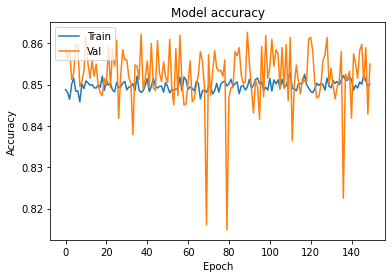

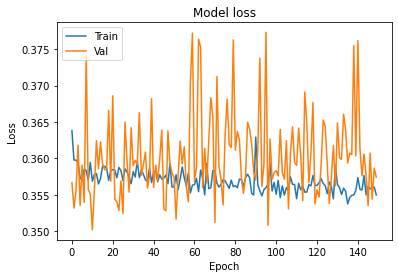

In [0]:
'''Plot training and validation accuracy values
'''
#epoch_range = range(1, epoch+1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

'''Plot training and validation loss values
'''
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

Performance seems to have saturated around 85% accuracy.

Thus, increasing the training sample size will likely not improve performamnce.

Our model is not overfitting as the validation accuracy is still higher than the training accuracy for the most part.

# Model Testing

In [0]:
import numpy as np 
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.pipeline import make_pipeline
import sklearn.preprocessing
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
#from sklearn.preprocessing import OneHotEncoder
#from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
#from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
#from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.linear_model import LogisticRegression
#from sklearn import svm
#from sklearn.svm import SVC
#from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
#from catboost import CatBoostClassifier
from sklearn.preprocessing import PowerTransformer


#from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import pickle
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

#to adjust figsize of plots
plt.rcParams['figure.figsize'] = (20,6)
pd.set_option('display.max_columns', None)

In [0]:
#Define data file path and target variable
file = '/content/drive/My Drive/back_order_predictor_v2/derived_data/validate_data.csv'
target = 'went_on_backorder_Yes'
#test_features = pd.read_csv('derived_data/test_data.csv')

In [0]:
class Data():
    '''Loads data, samples training data if specified, assigns features_df and target_df
    '''
    def __init__(self, file, target, sample=False, n_samples=None):
        self.file = file
        self. sample = sample
        self.n_sample = n_sample
        self.target = target
    
    def get_data(file, sample=False, n_samples=None):
        '''Loads train data with option to sample'''
        data = pd.read_csv(file)
        if sample:
            '''Sample train data due to resource limitation'''
            data = data.sample(n_samples, random_state=123)
        else:
            data = data
        print(data.shape, 'data loaded')
        return data
         
    def get_features():
        '''Assigns features dataframe'''
        features_df = data.drop(target, axis = 1)
        print(features_df.shape, 'features assigned')
        return features_df
        
    def get_target():
        '''Assigns target'''
        target_df = data[target].values
        print(target_df.shape, '...target rows loaded')
        return target_df
    

class FeatureSelector(BaseEstimator, TransformerMixin):
    '''Custom transformer to extract columns passed as arguments'''
    
    def __init__(self, feature_names):
        '''Class constructor'''
        self._feature_names = feature_names
        
    def fit(self, features_df, target = None):
        '''Returns self and nothing else'''
        return self
    
    def transform( self, features_df, target = None):
        '''This method returns selected features'''
        return features_df[ self._feature_names] 
    

class FeatureSelector(BaseEstimator, TransformerMixin):
    '''Custom transformer to extract columns passed as arguments'''
    
    def __init__(self, feature_names):
        '''Class constructor'''
        self._feature_names = feature_names
        
    def fit(self, features_df, target = None):
        '''Returns self and nothing else'''
        return self
    
    def transform( self, features_df, target = None):
        '''This method returns selected features'''
        return features_df[ self._feature_names] 
    

class DropMissing(BaseEstimator, TransformerMixin, object):
    '''Takes df, drops all observaions with missing values
    '''
    features_df_test = pd.DataFrame()
    def __init__(self, features_df):
        self.features_df = features_df

    def fit(self, features_df, target=None):
        return self
    
    def transform(self, features_df, target=None):
        features_df_test = features_df.dropna(axis = 0, how = 'any', inplace = False)
        return features_df_test
    

class PowerTransform(BaseEstimator, TransformerMixin):
    '''Takes df, applies power transformation
    '''
    def __init__(self, features_df, target=None):
        self.features_df = features_df
    
    def fit(self, features_df, target=None):
        return self

    def transform(self, features_df, target=None):
        power = PowerTransformer(method= 'yeo-johnson', standardize=True)
        
        #Apply power transformation to features df
        features_df = power.fit_transform(features_df)

        return features_df
    
class Models(object):
    '''This class holds all modeling objects
       Note: Instantiate any additional models to test as class variables below    
    '''
    pass

In [0]:
if __name__ == '__main__':
    
    #Load data
    data = Data.get_data(file, sample=True, n_samples = 10000)
    features_df = Data.get_features()
    target_df = Data.get_target()
    
    '''Data transformation pipelines'''
    #Categrical features to pass down categorical pipeline 
    categorical_features = ['oe_constraint_Yes', 'potential_issue_Yes',
                       'ppap_risk_Yes','stop_auto_buy_Yes']

    #Numerical features to pass down numerical pipeline 
    numerical_features = ['national_inv','in_transit_qty', 'sales_1_month',
                     'pieces_past_due']
    
    #Defining steps in the categorical pipeline 
    categorical_pipeline = Pipeline( steps = [('cat_selector', FeatureSelector(categorical_features)),
                                                                                                                              
                                              ('drop_missing', DropMissing(features_df)),
                                          
                                              ('power_transform', PowerTransform(features_df))
                                         
                                         ])
    
    #Defining the steps in the numerical pipeline 
    numerical_pipeline = Pipeline( steps = [('num_selector', FeatureSelector(numerical_features)),
                                        
                                            ('drop_missing', DropMissing(features_df)),
                                        
                                            ('power_transform', PowerTransform(features_df))
                                   
                                       ] )
    
    #Combine numerical and categorical pieplines horizontally using FeatureUnion
    full_pipeline = FeatureUnion( transformer_list = [('categorical_pipeline', categorical_pipeline), 
                                                  
                                                      ('numerical_pipeline', numerical_pipeline )])
    #Disabling pandas chained_assignment warning
    pd.options.mode.chained_assignment = None
    
    #Fitting data to data transformation pipeline
    prepared_features_df = full_pipeline.fit_transform(features_df, target_df)
    
    print(prepared_features_df)

(10000, 23) data loaded
(10000, 22) features assigned
(10000,) ...target rows loaded
[[-0.01414355 -0.03001351 -0.38141234 ...  1.16704256  1.36000114
  -0.12423609]
 [-0.01414355 -0.03001351 -0.38141234 ...  1.98863367  0.17598154
  -0.12423609]
 [-0.01414355 -0.03001351  2.62183442 ... -0.50575267  0.17598154
  -0.12423609]
 ...
 [-0.01414355 -0.03001351 -0.38141234 ... -0.50575267 -0.81542333
  -0.12423609]
 [-0.01414355 -0.03001351 -0.38141234 ... -0.50575267 -0.81542333
  -0.12423609]
 [-0.01414355 -0.03001351 -0.38141234 ... -0.50575267 -0.81542333
  -0.12423609]]


In [0]:
prepared_features_df

array([[-0.01414355, -0.03001351, -0.38141234, ...,  1.16704256,
         1.36000114, -0.12423609],
       [-0.01414355, -0.03001351, -0.38141234, ...,  1.98863367,
         0.17598154, -0.12423609],
       [-0.01414355, -0.03001351,  2.62183442, ..., -0.50575267,
         0.17598154, -0.12423609],
       ...,
       [-0.01414355, -0.03001351, -0.38141234, ..., -0.50575267,
        -0.81542333, -0.12423609],
       [-0.01414355, -0.03001351, -0.38141234, ..., -0.50575267,
        -0.81542333, -0.12423609],
       [-0.01414355, -0.03001351, -0.38141234, ..., -0.50575267,
        -0.81542333, -0.12423609]])

In [0]:
# make probability predictions with the model
predictions = model.predict(prepared_features_df)
# round predictions 
rounded = [round(x[0]) for x in predictions]

In [0]:
#Sanity check first five predictions
rounded[:5]

[1.0, 0.0, 1.0, 0.0, 0.0]

In [0]:
#Get the confusion matrix
cf_matrix = confusion_matrix(rounded, target_df)
print(cf_matrix)

[[7251   41]
 [2693   15]]


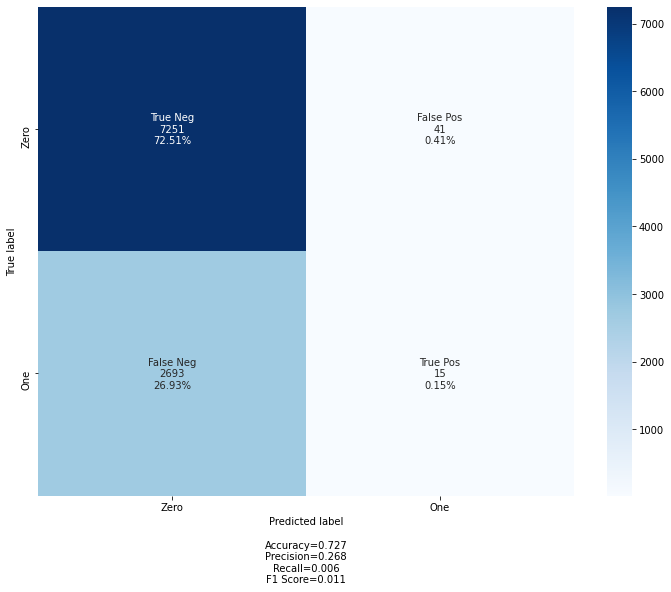

In [0]:
#Pretty confusion_matrix
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix.make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories,
                      figsize=(12, 9)
                     )